In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression 
from sklearn.impute import SimpleImputer, KNNImputer

In [2]:
n=500
np.random.seed(109) #to create same random numbers for every run
x1 = np.random.normal(0, 1, size=n) #(mean, standard deviation)
x2 = 0.5*x1 + np.random.normal(0, np.sqrt(0.75), size=n)  #x2 to have some linear relationsjip with x1 with some random noise
X = pd.DataFrame(data=np.transpose([x1, x2]), columns=['x1', 'x2'])

y = 3*x1 - 2*x2 + np.random.normal(0, 1, size=n)
y = pd.Series(y)

df = pd.DataFrame(data=np.transpose([x1, x2, y]), columns = ['x1', 'x2', 'y'])
df.head()

,x1,x2,y
0,-0.187735,1.190834,-1.687270
1,2.440637,2.214195,3.816174
2,-0.940908,-0.474695,-0.564044
3,0.613912,1.434117,-2.632183
4,0.735627,1.282782,0.133237


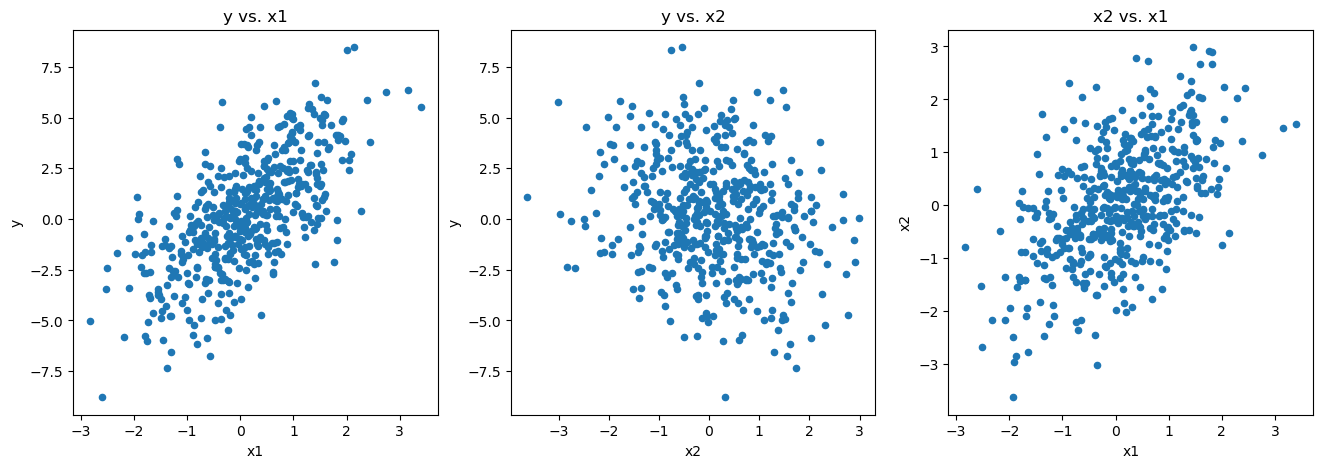

In [3]:
fig, axs =  plt.subplots(1, 3, figsize = (16,5))

plot_pairs = [('x1', 'y'), ('x2', 'y'), ('x1', 'x2')]
for ax, (x_var, y_var) in zip(axs, plot_pairs):
    df.plot.scatter(x_var, y_var, ax=ax, title=f'{y_var} vs. {x_var}')

In [4]:
missing_A = np.random.binomial(1, 0.05 + 0.85*(y > (y.mean()+y.std())),  n).astype(bool)
missing_B = np.random.binomial(1, 0.2, n).astype(bool)
missing_C = np.random.binomial(1, 0.05 + 0.85*(x2 > (x2.mean()+x2.std())), n).astype(bool)

In [5]:
def create_missing(missing_indices, df=df):
    df_new = df.copy()
    df_new.loc[missing_indices, 'x1'] = np.nan
    return df_new

In [6]:
# Missing completely at random (MCAR)
df_mcar = create_missing(missing_indices=missing_A)

# Missing at random (MAR)
df_mar = create_missing(missing_indices=missing_B)

# Missing not at random (MNAR)
df_mnar = create_missing(missing_indices=missing_C)

### Drop the null values and use Linear Regression

#### no missing data

In [7]:
lnrg = LinearRegression().fit(df[['x1', 'x2']], df['y'])
print('No missing data: ', lnrg.coef_, lnrg.intercept_)

No missing data:  [ 2.92281015 -1.93658251] 0.10204379528391672


#### MCAR

In [8]:
try:
    ouch = LinearRegression().fit(df_mcar[['x1','x2']],df_mcar['y'])
except Exception as e:
    print(e)

Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [9]:
lnrg = LinearRegression().fit(df_mcar.dropna()[['x1', 'x2']], df_mcar.dropna()['y'])
print('MCAR data: ', lnrg.coef_, lnrg.intercept_)

MCAR data:  [ 2.77095031 -1.84859735] 0.020221283325560724


#### MAR

In [10]:
lnrg = LinearRegression().fit(df_mar.dropna()[['x1', 'x2']], df_mar.dropna()['y'])
print('MAR data: ', lnrg.coef_, lnrg.intercept_)

MAR data:  [ 2.95778269 -1.90922895] 0.09607569437217287


#### MNAR

In [11]:
lnrg = LinearRegression().fit(df_mnar.dropna()[['x1', 'x2']], df_mnar.dropna()['y'])
print('MNAR data: ', lnrg.coef_, lnrg.intercept_)

MNAR data:  [ 2.93256228 -1.89351279] 0.14606481117880465


In [12]:
X_mcar_raw = df_mcar.drop('y', axis=1).copy()
X_mar_raw = df_mar.drop('y', axis=1).copy()
X_mnar_raw = df_mnar.drop('y', axis=1).copy()

### Imputation with mean

In [13]:
X_mcar = X_mcar_raw.copy()
X_mcar['x1'] = X_mcar['x1'].fillna(X_mcar['x1'].dropna().mean())

lnrg_mcar_mean = lnrg.fit(X_mcar, y)
print('MCAR mean data: ', lnrg_mcar_mean.coef_, lnrg_mcar_mean.intercept_)

MCAR mean data:  [ 2.64232555 -1.67075578] 0.520706160894387


In [14]:
X_mar = X_mar_raw.copy()
X_mar['x1'] = X_mar['x1'].fillna(X_mar['x1'].dropna().mean())

lnrg_mar_mean = lnrg.fit(X_mar, y)
print('MAR mean data: ', lnrg_mar_mean.coef_, lnrg_mar_mean.intercept_)

MAR mean data:  [ 2.76751051 -1.56434888] 0.06518722125657422


In [15]:
X_mnar = X_mnar_raw.copy()
X_mnar['x1'] = X_mnar['x1'].fillna(X_mnar['x1'].dropna().mean())

lnrg_mnar_mean = lnrg.fit(X_mnar, y)
print('MNAR mean data: ', lnrg_mnar_mean.coef_, lnrg_mnar_mean.intercept_)

MNAR mean data:  [ 2.62546455 -1.22434111] 0.3922738786668911


### Imputation with Linear Regression

In [16]:
X_mcar = X_mcar_raw.copy()

# Fit the imputation model
ols_imputer_mcar = LinearRegression().fit(X_mcar.dropna()[['x2']], X_mcar.dropna()['x1'])

# Perform some imputations
yhat_impute = pd.Series(ols_imputer_mcar.predict(X_mcar[['x2']])) #predict x1 using x2
X_mcar['x1'] = X_mcar['x1'].fillna(yhat_impute)

# Fit the model we care about
ols_mcar_ols = LinearRegression().fit(X_mcar, y)
print('MCAR (OLS):', ols_mcar_ols.coef_, ols_mcar_ols.intercept_)

MCAR (OLS): [ 2.77095031 -1.97302957] 0.6148065869266277


In [17]:
X_mar = X_mar_raw.copy()

# Fit the imputation model
ols_imputer_mar = LinearRegression().fit(X_mar.dropna()[['x2']], X_mar.dropna()['x1'])

# Perform some imputations
yhat_impute = pd.Series(ols_imputer_mar.predict(X_mar[['x2']])) #predict x1 using x2
X_mar['x1'] = X_mar['x1'].fillna(yhat_impute)

# Fit the model we care about
ols_mar_ols = LinearRegression().fit(X_mar, y)
print('MAR (OLS):', ols_mar_ols.coef_, ols_mar_ols.intercept_)

MAR (OLS): [ 2.95778269 -1.91346654] 0.11835122909536361


In [18]:
X_mnar = X_mnar_raw.copy()

# Fit the imputation model
ols_imputer_mnar = LinearRegression().fit(X_mnar.dropna()[['x2']], X_mnar.dropna()['x1'])

# Perform some imputations
yhat_impute = pd.Series(ols_imputer_mnar.predict(X_mnar[['x2']])) #predict x1 using x2
X_mnar['x1'] = X_mnar['x1'].fillna(yhat_impute)

# Fit the model we care about
ols_mnar_ols = LinearRegression().fit(X_mnar, y)
print('MNAR (OLS):', ols_mnar_ols.coef_, ols_mnar_ols.intercept_)

MNAR (OLS): [ 2.93256228 -1.99438598] 0.007334836526979499


### kNN Imputation

In [20]:
X_mcar = X_mcar_raw.copy()

X_mcar = KNNImputer(n_neighbors=3).fit_transform(X_mcar)

ols_mcar_knn = LinearRegression().fit(X_mcar,y)

print('MCAR (KNN):', ols_mcar_knn.coef_, ols_mcar_knn.intercept_)

MCAR (KNN): [ 2.62065071 -1.93067768] 0.635851123451955


In [21]:
X_mar = X_mar_raw.copy()

X_mar = KNNImputer(n_neighbors=3).fit_transform(X_mar)

ols_mar_knn = LinearRegression().fit(X_mar,y)

print('MAR (KNN):', ols_mar_knn.coef_, ols_mar_knn.intercept_)

MAR (KNN): [ 2.78459666 -1.85426345] 0.15134915515799063


In [22]:
X_mnar = X_mnar_raw.copy()

X_mnar = KNNImputer(n_neighbors=3).fit_transform(X_mnar)

ols_mnar_knn = LinearRegression().fit(X_mnar,y)

print('MNAR (KNN):', ols_mnar_knn.coef_, ols_mnar_knn.intercept_)

MNAR (KNN): [ 2.72661518 -1.55667191] 0.24560978941317949
